In [1]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW
from scipy.optimize import minimize, fsolve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import os
import gc
from tqdm import tqdm
import sys
sys.path.append("../src")
from config import read_config, update_config
from metric import cal_mae_metric
from util import smart_avg,reduce_mem_usage
from FE import add_features_choice
from dataset import read_data, prepare_train_valid, VPP, cls_2_num_func
from models import get_model
from util import *

In [2]:
config = read_config("Base")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/Base/


In [3]:
subs = {
    "Public_PulpFriction_New": "../output/Public_PulpFriction_New/test_pred_all_16499.csv",
    "Public_PulpFriction_New_Physics": "../output/Public_PulpFriction_New_Physics/test_pred_all_16515.csv",
    
    "LSTM5_CLS_FIXED_NoErr1_noCS_PL": "../output/LSTM5_CLS_FIXED_NoErr1_noCS_PL/test_pred_all_14748.csv",
    "LSTM5_REG_LARGER_physics_noCS_noErr1_PL": "../output/LSTM5_REG_LARGER_physics_noCS_noErr1_PL/test_pred_all_15036.csv",
    
    "LSTM5_REG_physics_PL_better_2": "../output/LSTM5_REG_physics_PL_better_2/test_pred_all_17501.csv",
    "LSTM5_REG_physics_noCS_PL" : "../output/LSTM5_REG_physics_noCS_PL/test_pred_all_16991.csv",
    "LSTM5_REG_LARGER_physics_noCS_PL":"../output/LSTM5_REG_LARGER_physics_noCS_PL/test_pred_all_16841.csv",
    
    "LSTM5_CLS_FIXED_noCS_PL": "../output/LSTM5_CLS_FIXED_noCS_PL/test_pred_all_16417.csv",
    "LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL":"../output/LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL/test_pred_all_17199.csv",
    "LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3": "../output/LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3/test_pred_all_17136.csv",
    "LSTM5_CLS_LARGER512x3842x2562_noCS_PL": "../output/LSTM5_CLS_LARGER512x3842x2562_noCS_PL/test_pred_all_15908.csv"
}
ensemble_folder = config.output_folder + "/" + "ensemble_1102"
if not os.path.exists(ensemble_folder):
    os.makedirs(ensemble_folder)

In [4]:
train, test = read_data(config)

In [5]:
pressure_unique = np.load("/home/vincent/Kaggle/GBVPP/input/pressure_unique.npy")

In [6]:
P_MIN = np.min(pressure_unique)
P_MAX = np.max(pressure_unique)
P_STEP = pressure_unique[1] - pressure_unique[0]
def transform_pv(s):
    t = (np.round((s - P_MIN) / P_STEP) * P_STEP + P_MIN)
    return np.clip(t, P_MIN, P_MAX)

# Regenerate Valid Prediction If necessary

In [7]:
def get_valid_pred(valid_loader, model, device):
    model.eval()
    preds = []
    for step, batch in enumerate(valid_loader, 1):
        with torch.no_grad():
            X = batch[0].to(device)
            outputs = model(X).squeeze()
            preds.append(outputs.to('cpu').detach().numpy())
    predictions = np.concatenate(preds, axis=0)
    return predictions

In [8]:
key = None
key_cvs = []
if key is not None:
    print(f"Check Model {key} CV")
    model_config =  read_config(key)
    model_config.gpu = [1]
    model_config = update_config(model_config)
    train = add_features_choice(train.copy(), model_config)
    train, NAlist = reduce_mem_usage(train)
    for fold in range(5):
        X_train, y_train, w_train, X_valid, y_valid, w_valid = prepare_train_valid(train.copy(), model_config, fold)
        valid_dt = VPP(X_valid, y_valid, w_valid, model_config)
        valid_loader = DataLoader(valid_dt,
                                  batch_size=model_config.batch_size,
                                  shuffle=False,
                                  num_workers=model_config.num_workers, pin_memory=True, drop_last=False)       
        model = get_model(X_valid.shape[-1], model_config)
        checkpoint = torch.load(f'{model_config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict((checkpoint['model_state_dict']))
        print("Model Size: {}".format(get_n_params(model)))
        model.to(model_config.device)
        oof_preds = get_valid_pred(valid_loader, model, model_config.device)
        if not model_config.do_reg:
            oof_preds = cls_2_num_func(oof_preds.argmax(axis=-1), model_config.pressure_unique_path)
        cv = (np.abs( oof_preds-y_valid ) * w_valid).sum()/w_valid.sum()
        key_cvs.append(cv)
        print(f"Fold {fold}, CV: {cv:.5f}")
        np.save(model_config.model_output_folder + f"/oof{fold}", oof_preds)

# Read Data

In [9]:
sub_all = None
for key, sub_file in tqdm(subs.items()):
    train[key] = 0
    tmp = pd.read_csv(sub_file)
    if sub_all is None:
        sub_all = tmp[["id","pressure"]].copy()
        sub_all["pressure"] = 0
        
    for fold in range(5):
        if "Public_PulpFriction" in key or "noerr1" in key.lower():
            train.loc[train.query(f"fold=={fold}").index, key] = np.load(f'../output/{key}/oof{fold}.npy').flatten()
        else:
            train.loc[train.query(f"fold=={fold}").index, key] = torch.load(f'../output/{key}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()
        sub_all[key+f"_{fold}"] = tmp[f"preds_fold{fold}"]
    train[key] = transform_pv(train[key])
    sub_all[key] = smart_avg(sub_all[[key+f"_{f}" for f in range(5)]],axis=1)
    sub_all[key] = transform_pv(sub_all[key])

100%|███████████████████████████████████████████████████████████████████████████| 11/11 [00:57<00:00,  5.23s/it]


In [10]:
for key, sub_file in subs.items():
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"Model {key} CV {CV:.5f}")

Model Public_PulpFriction_New CV 0.16499
Model Public_PulpFriction_New_Physics CV 0.16515
Model LSTM5_CLS_FIXED_NoErr1_noCS_PL CV 0.16463
Model LSTM5_REG_LARGER_physics_noCS_noErr1_PL CV 0.16767
Model LSTM5_REG_physics_PL_better_2 CV 0.17501
Model LSTM5_REG_physics_noCS_PL CV 0.16991
Model LSTM5_REG_LARGER_physics_noCS_PL CV 0.16841
Model LSTM5_CLS_FIXED_noCS_PL CV 0.16417
Model LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL CV 0.17199
Model LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3 CV 0.17136
Model LSTM5_CLS_LARGER512x3842x2562_noCS_PL CV 0.15908


In [11]:
model_cols = list(subs.keys())
train["oof_avg"] =  transform_pv(train[model_cols].mean(axis=1))
train["oof_median"] =  transform_pv(train[model_cols].median(axis=1))
train["oof_smart"] =  transform_pv(smart_avg(train[model_cols], axis=1))
for key in ['oof_avg', 'oof_median', 'oof_smart']:
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"{key} CV {CV:.5f}")

oof_avg CV 0.14903
oof_median CV 0.14716
oof_smart CV 0.14682


In [12]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,Public_PulpFriction_New,...,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_REG_LARGER_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_avg,oof_median,oof_smart
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.837492,...,5.767190,5.978096,5.837492,5.767190,5.837492,5.767190,5.837492,5.837492,5.837492,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.978096,...,5.837492,5.907794,5.837492,5.837492,5.907794,5.837492,5.837492,5.907794,5.837492,5.907794
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,8.016858,...,7.946556,7.876254,7.876254,7.805952,7.946556,7.876254,7.876254,7.876254,7.876254,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.883476,...,11.813174,11.813174,11.953778,11.883476,11.883476,11.883476,11.953778,11.883476,11.883476,11.883476
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.375591,...,12.516196,12.516196,12.586498,12.516196,12.516196,12.445893,12.516196,12.516196,12.516196,12.516196


In [13]:
sub_all.head()

,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,Public_PulpFriction_New_Physics_0,Public_PulpFriction_New_Physics_1,...,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_0,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_1,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_2,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_4,LSTM5_CLS_LARGER512x3842x2562_noCS_PL
0,1,0,6.329606,6.329606,6.329606,6.259304,6.329606,6.329607,6.329606,6.259304,...,6.259305,6.259305,6.189002,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305
1,2,0,5.978096,5.978096,5.978096,5.907794,5.978096,5.978096,5.978096,5.978096,...,5.907794,5.907794,5.978096,5.907794,5.978096,5.978096,5.907794,5.907794,5.978096,5.978096
2,3,0,7.032628,7.173232,7.102930,7.102930,7.173232,7.102930,6.962326,7.102930,...,7.102930,7.102930,7.102930,7.102930,7.102930,7.173232,7.102930,7.102930,7.102930,7.102930
3,4,0,7.595045,7.735649,7.595045,7.595045,7.665347,7.665347,7.665347,7.665347,...,7.524743,7.665347,7.665347,7.595045,7.595045,7.595045,7.595045,7.595045,7.665347,7.595045
4,5,0,9.141692,9.211994,9.001088,9.141692,9.141692,9.141693,9.141692,9.282296,...,9.001088,9.141693,9.071390,9.071390,9.071390,9.141693,9.071390,9.141693,9.141693,9.141693


# Error Analysis

In [36]:
def plot_error(df, ax, breath_id):
    breath = df.query(f"breath_id == {breath_id}").copy()
    R, C = breath.iloc[0][["R","C"]]
    best_choice = None
    best_score = np.inf
    for col in ["oof_smart", "Public_PulpFriction_New_Physics", "LSTM5_CLS_FIXED_NoErr1_noCS_PL", 
                "LSTM5_REG_physics_noCS_PL", "LSTM5_CLS_LARGER512x3842x2562_noCS_PL"]:
        score = np.mean(np.abs(breath["pressure"] - breath[col]))
        if score < best_score:
            best_score = score
            best_choice = col
    
    ax.plot(breath["time_step"],breath["pressure"],label="y_true")
    ax.plot(breath["time_step"],breath["oof_smart"],label="y_pred")
    #ax.plot(breath["time_step"],breath["u_in"],label="u_in")
    
    ax.plot(breath["time_step"],breath["Public_PulpFriction_New_Physics"],label="p_pulp")
    ax.plot(breath["time_step"],breath["LSTM5_CLS_FIXED_NoErr1_noCS_PL"],label="p_noErr1")
    ax.plot(breath["time_step"],breath["LSTM5_REG_physics_noCS_PL"],label="p_reg")
    ax.plot(breath["time_step"],breath["LSTM5_CLS_LARGER512x3842x2562_noCS_PL"],label="p_cls")    
    
    
#     diff = breath["pressure"] - breath["oof_smart"]
#     ax2 = ax.twinx()
#     ax2.plot(breath["time_step"], diff, label='diff', color="red")
#     ax2.axhline(y=CV, color="red", linestyle="--", alpha=.3)
#     ax2.axhline(y=0, color="red", linestyle="--", alpha=.3)
#     ax2.axhline(y=-CV, color="red", linestyle="--", alpha=.3)
    ax.legend(loc="lower right")
#     ax2.legend(loc="upper right")
    ax.set_title(f"id: {breath_id}, R:{R}, C:{C}. Best Choice: {best_choice}")
    ax.grid(axis='x')

In [93]:
related_train = train.query("u_out == 0").copy()
RC_score = related_train.groupby(["R","C"]).apply(lambda df: np.mean(np.abs(df["pressure"] - df["oof_smart"])))
RC_score

R   C 
5   10    0.137634
    20    0.093306
    50    0.098315
20  10    0.139580
    20    0.139999
    50    0.138226
50  10    0.138888
    20    0.212818
    50    0.226555
dtype: float64

In [17]:
breath_score = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"] - df["oof_smart"])))

In [18]:
bad_score = breath_score[breath_score > 1]

In [20]:
len(bad_score)

818

In [21]:
good_score = breath_score[breath_score < .1]

In [22]:
len(good_score)

43131

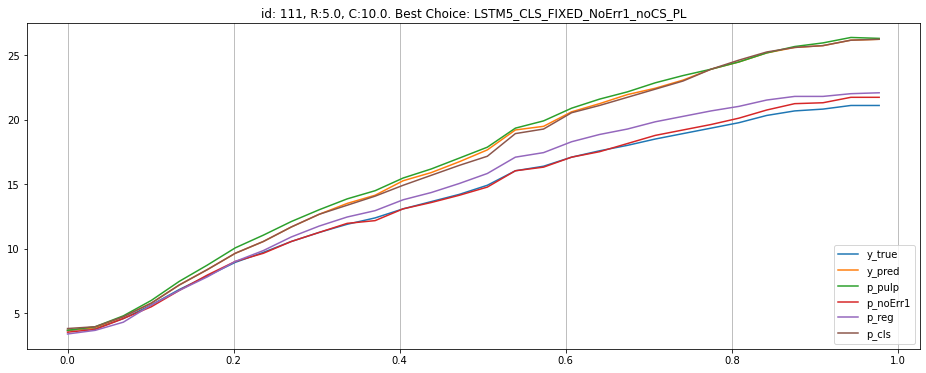

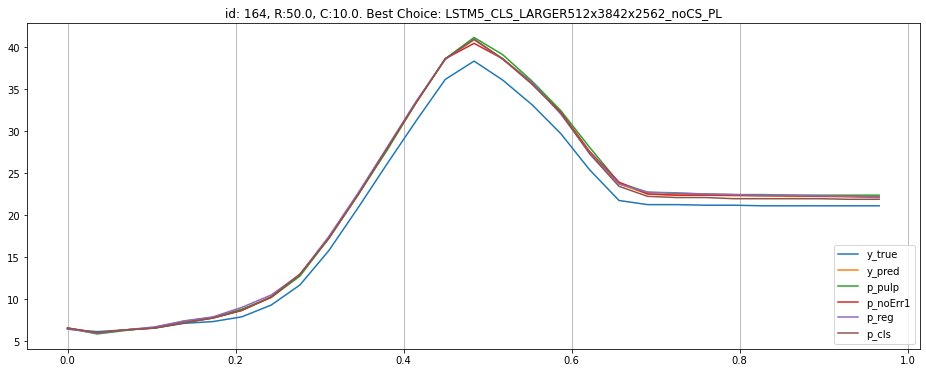

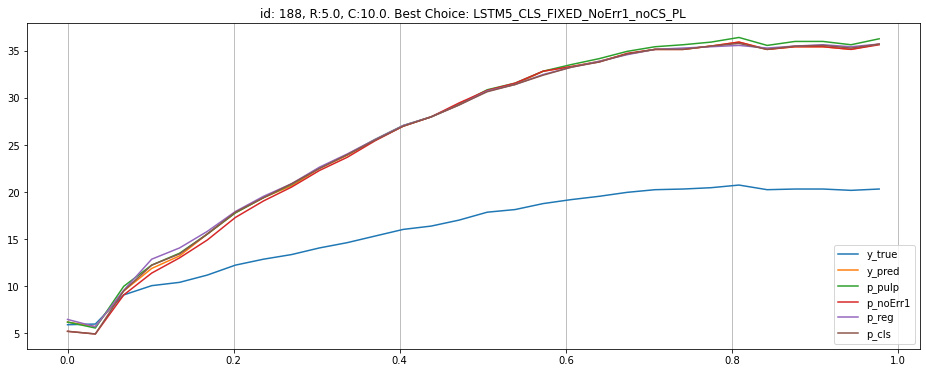

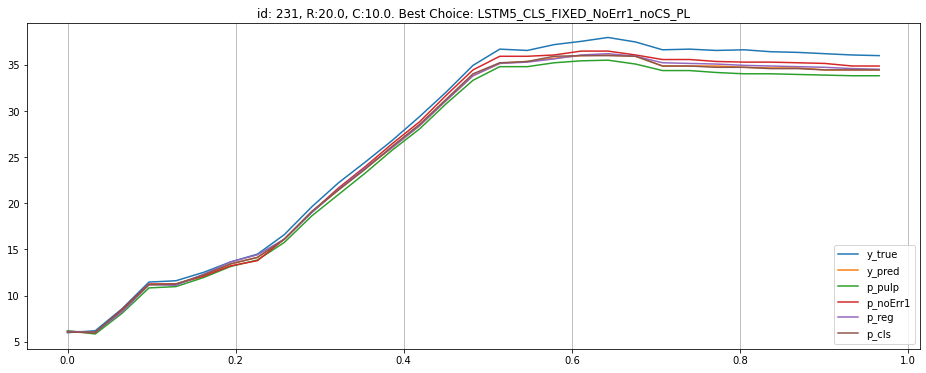

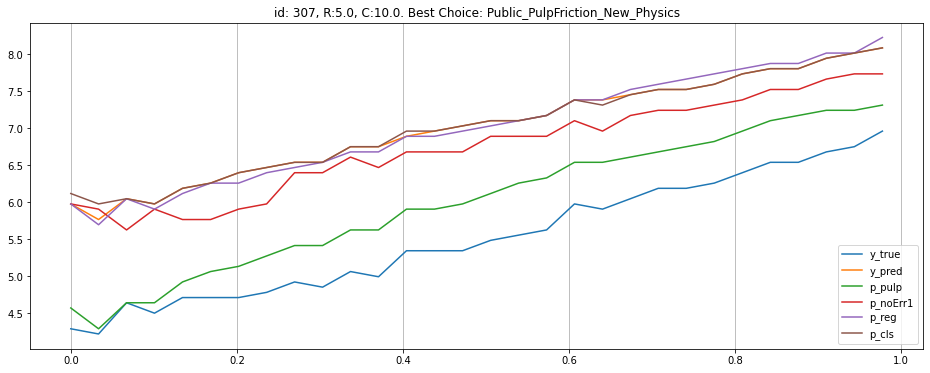

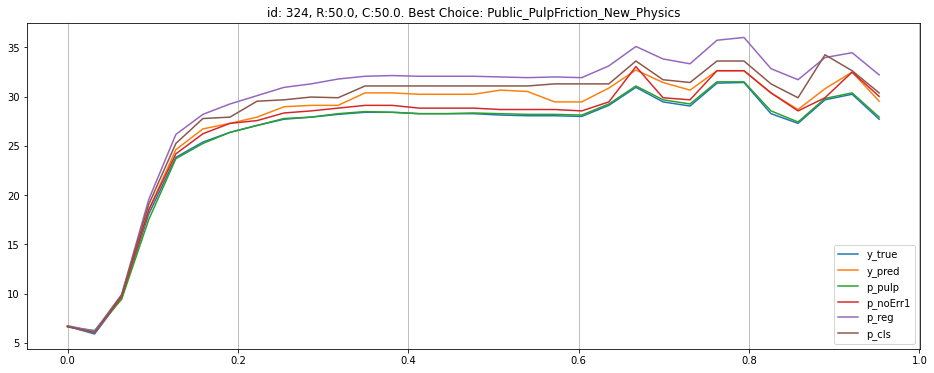

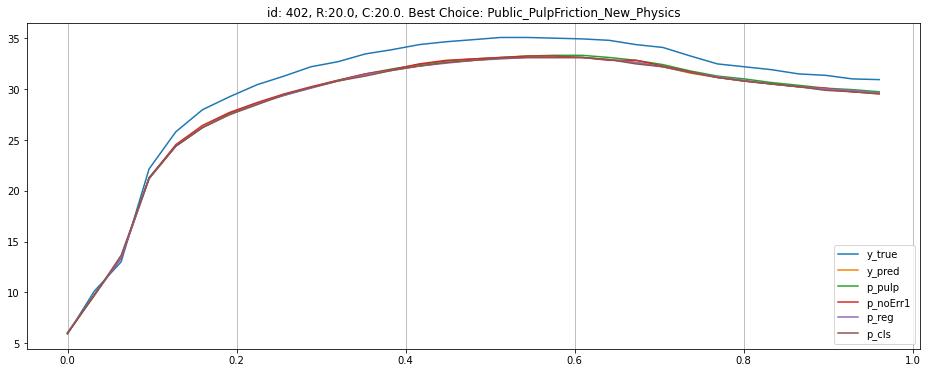

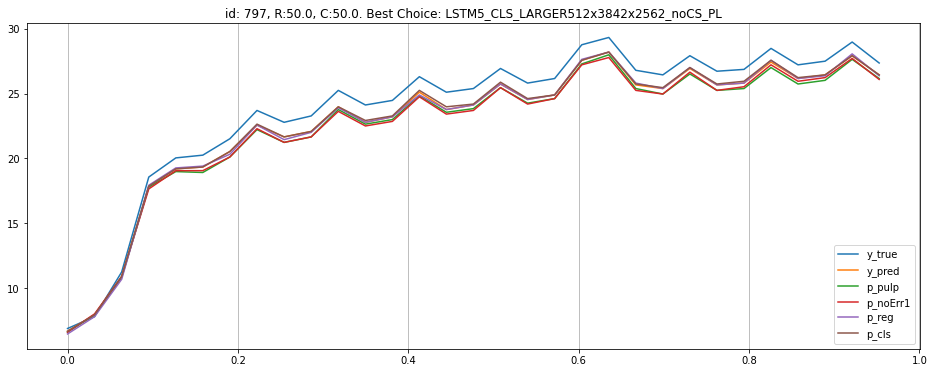

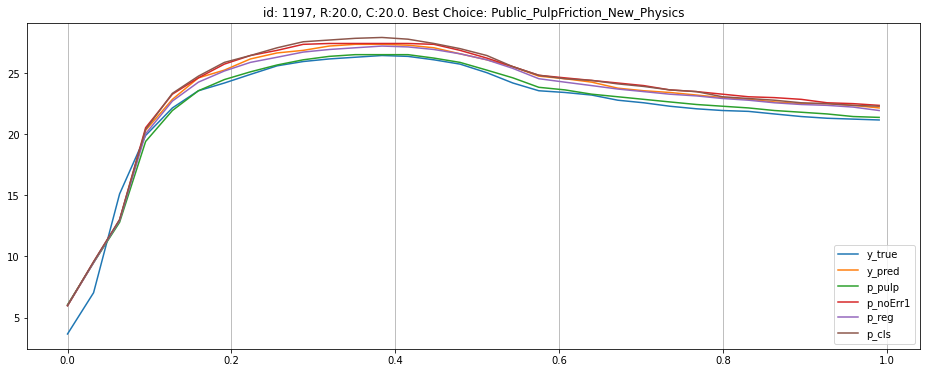

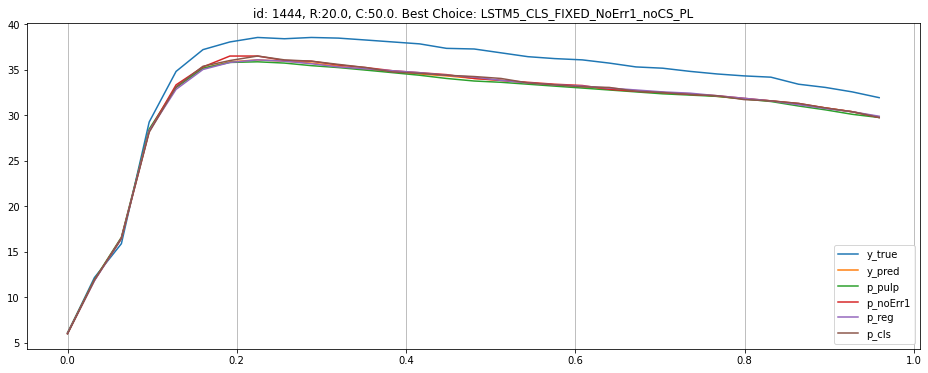

In [37]:
for i in range(10):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, bad_score.index[i])

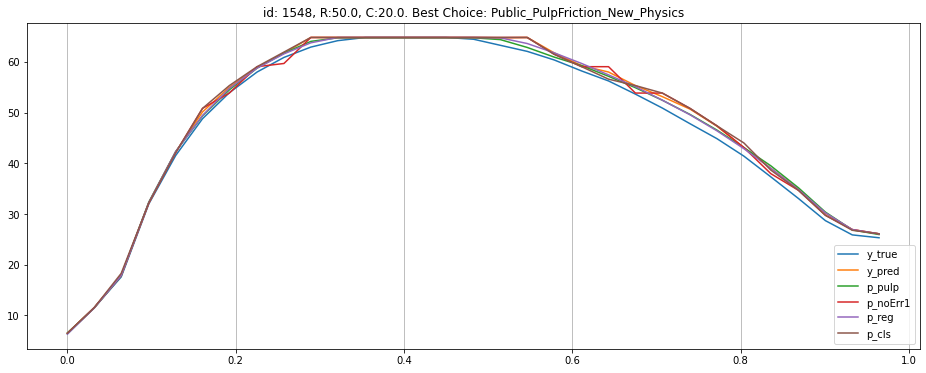

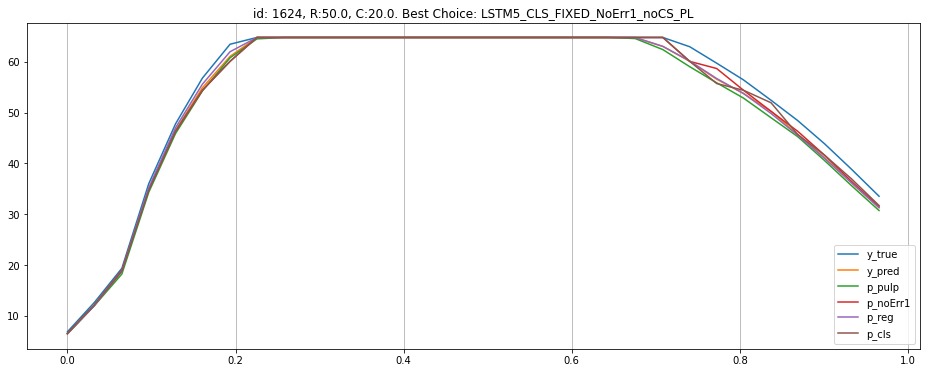

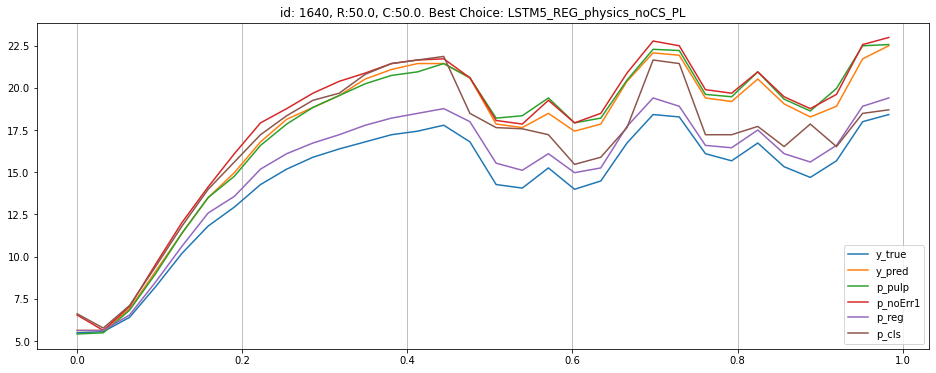

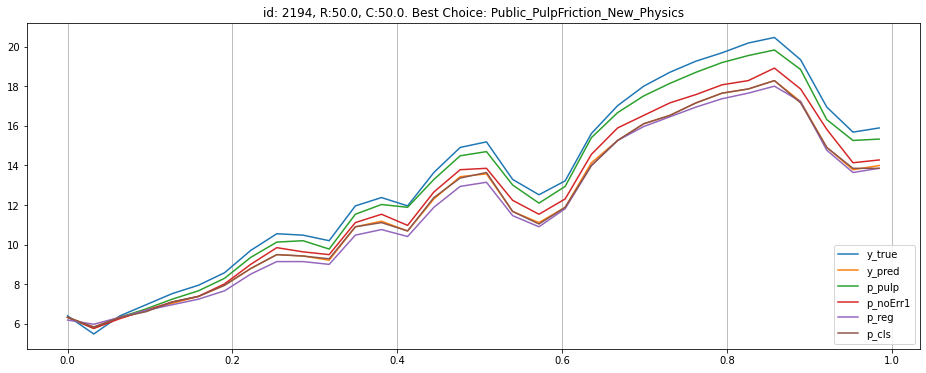

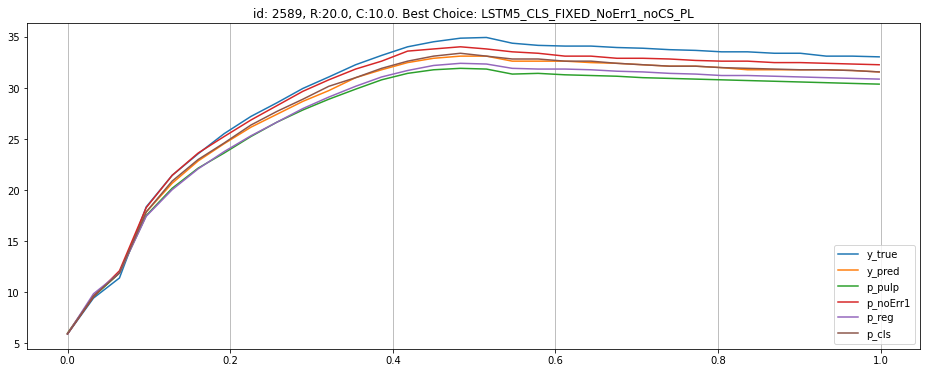

In [38]:
for i in range(10, 15):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, bad_score.index[i])

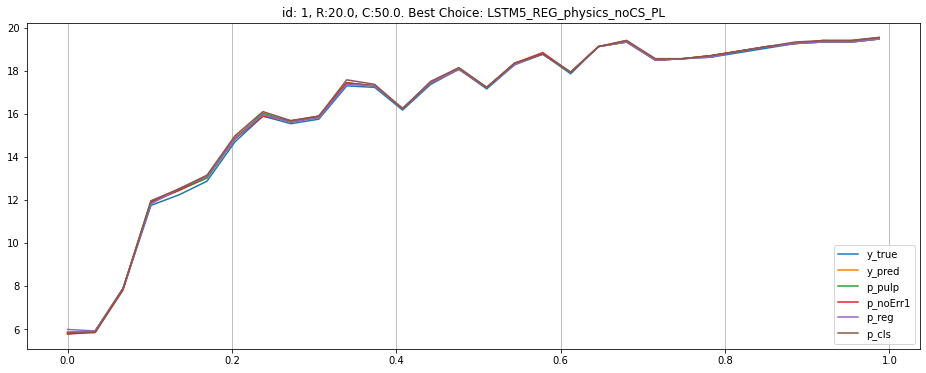

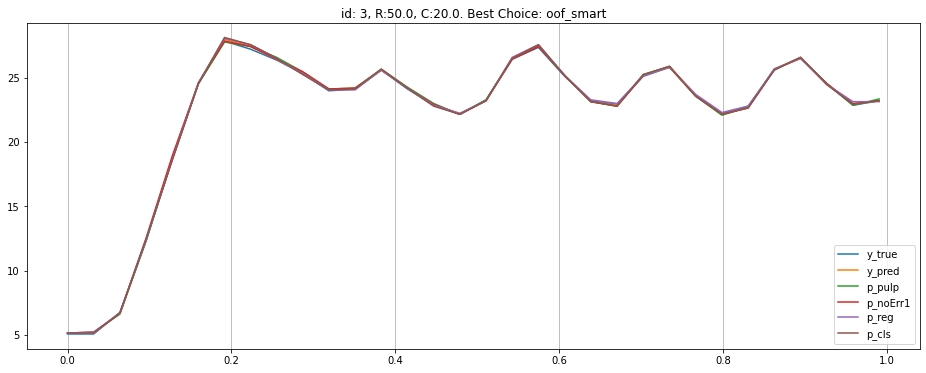

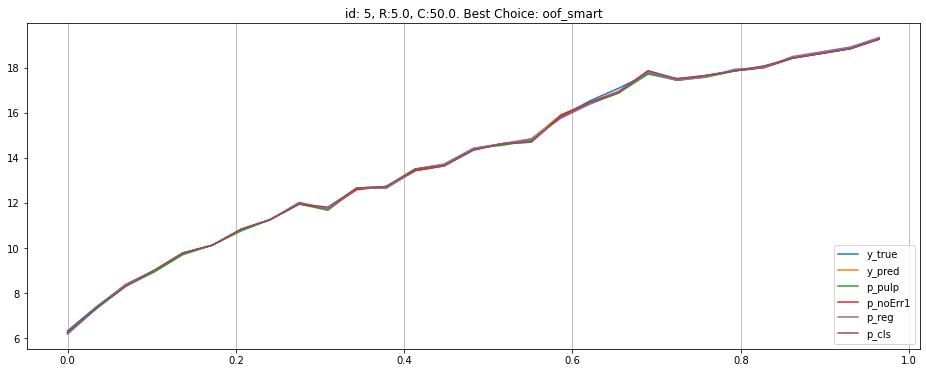

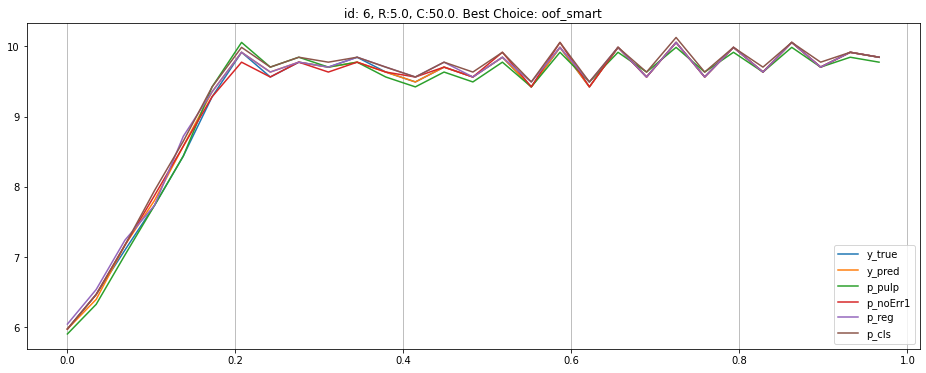

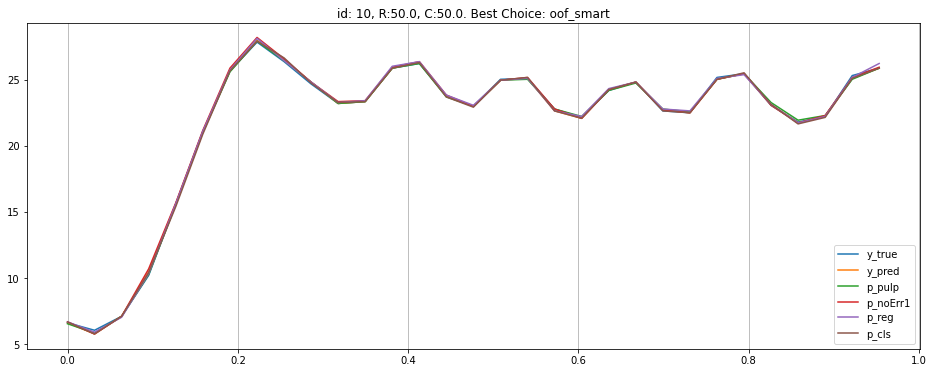

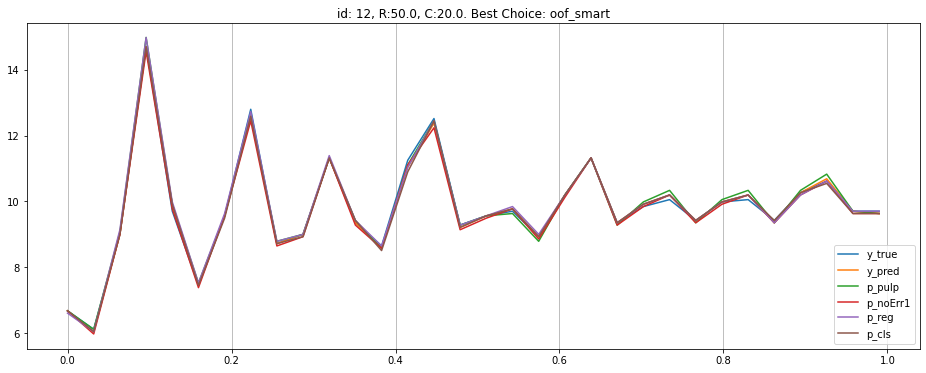

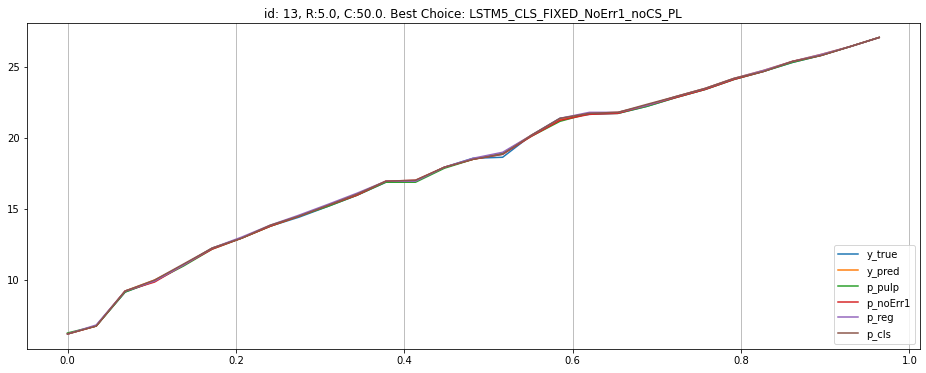

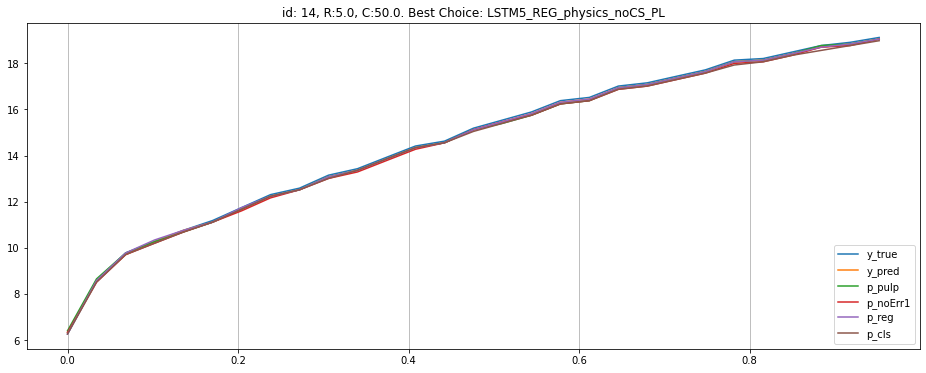

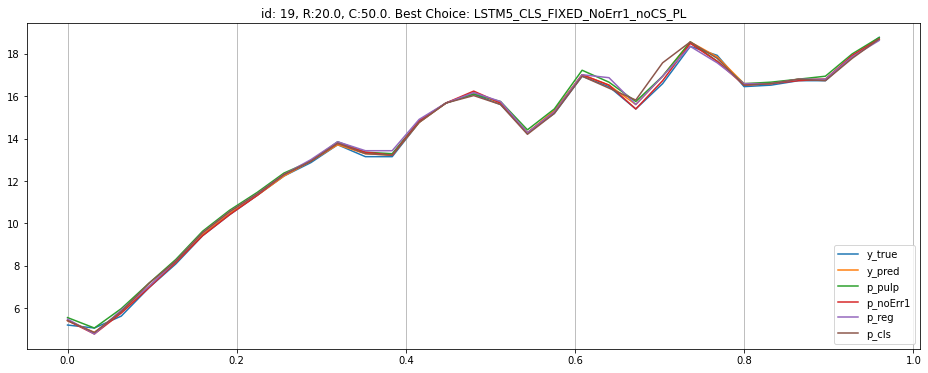

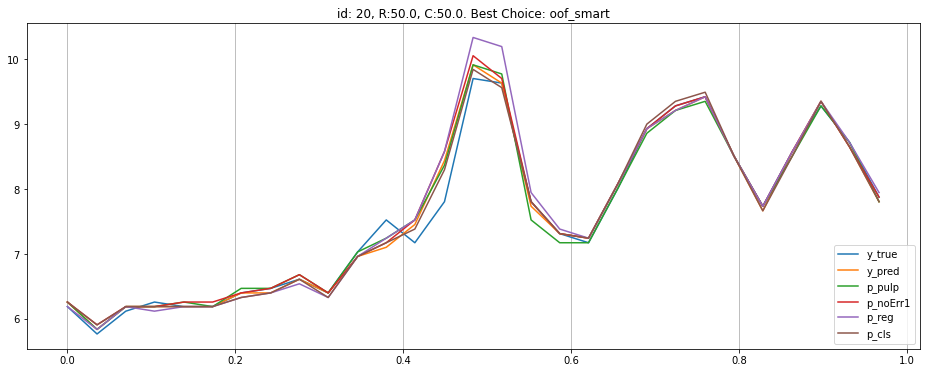

In [39]:
for i in range(10):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, good_score.index[i])

In [70]:
breath_score_df = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"]-df['oof_smart']))).to_frame(name="oof_smart")
for col in tqdm(model_cols + ["oof_median","oof_avg"]):
    breath_score_df[col] = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"]-df[col])))

100%|███████████████████████████████████████████████████████████████████████████| 11/11 [02:46<00:00, 15.10s/it]


In [84]:
breath_score_df.drop(columns=["best_choice"],inplace=True)

In [85]:
breath_score_df["best_choice"] = breath_score_df.idxmin(axis=1)

In [86]:
breath_score_df["R"] = related_train.groupby("breath_id")["R"].last()
breath_score_df["C"] = related_train.groupby("breath_id")["C"].last()

In [87]:
breath_score_df.head()

,oof_smart,Public_PulpFriction_New,Public_PulpFriction_New_Physics,LSTM5_CLS_FIXED_NoErr1_noCS_PL,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_median,oof_avg,best_choice,R,C
breath_id,,,,,,,,,,,,,,,
1,0.060929,0.044525,0.065615,0.077332,0.065615,0.053898,0.084363,0.100766,0.089049,0.105453,0.072646,0.060929,Public_PulpFriction_New,20,50
2,0.104241,0.121211,0.067878,0.155150,0.218179,0.077575,0.162422,0.082423,0.072726,0.104241,0.096968,0.104241,Public_PulpFriction_New_Physics,20,20
3,0.059317,0.079090,0.083484,0.083484,0.087878,0.092272,0.090075,0.090075,0.068105,0.087878,0.061514,0.059317,oof_smart,50,20
4,0.136210,0.221891,0.213103,0.166968,0.204316,0.213103,0.153786,0.202119,0.134013,0.107650,0.136210,0.136210,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,50,50
5,0.026666,0.065454,0.043636,0.036363,0.041212,0.043636,0.019394,0.050908,0.041212,0.036363,0.026666,0.026666,LSTM5_CLS_FIXED_noCS_PL,5,50


In [88]:
best_counts = breath_score_df["best_choice"].value_counts()
best_counts

Public_PulpFriction_New_Physics             11681
Public_PulpFriction_New                     10404
LSTM5_CLS_LARGER512x3842x2562_noCS_PL        7583
LSTM5_REG_physics_noCS_PL                    6859
oof_smart                                    6403
LSTM5_REG_physics_PL_better_2                6090
LSTM5_CLS_FIXED_NoErr1_noCS_PL               5529
LSTM5_CLS_FIXED_noCS_PL                      5324
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL      5061
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3     3916
oof_median                                   3526
oof_avg                                      3074
Name: best_choice, dtype: int64

In [94]:
related_train["max_pred"] = related_train[model_cols].max(axis=1)
related_train["min_pred"] = related_train[model_cols].min(axis=1)
related_train["spread"] = related_train["max_pred"] - related_train["min_pred"]

In [96]:
breath_score_df["max_spread"] = related_train.groupby("breath_id")['spread'].max()
breath_score_df["min_spread"] = related_train.groupby("breath_id")['spread'].min()
breath_score_df["mean_spread"] = related_train.groupby("breath_id")['spread'].mean()
breath_score_df["median_spread"] = related_train.groupby("breath_id")['spread'].median()

In [108]:
mean_spread_thresh = breath_score_df.groupby("best_choice")["mean_spread"].mean().sort_values()
median_spread_thresh = breath_score_df.groupby("best_choice")["median_spread"].median().sort_values()
mean_spread_thresh

best_choice
oof_smart                                   0.220004
oof_median                                  0.232738
LSTM5_CLS_LARGER512x3842x2562_noCS_PL       0.292667
LSTM5_CLS_FIXED_noCS_PL                     0.300588
LSTM5_REG_physics_noCS_PL                   0.303552
Public_PulpFriction_New_Physics             0.307243
Public_PulpFriction_New                     0.309437
LSTM5_REG_physics_PL_better_2               0.311277
LSTM5_CLS_FIXED_NoErr1_noCS_PL              0.316839
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3    0.322508
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL     0.324443
oof_avg                                     0.373674
Name: mean_spread, dtype: float64

In [109]:
median_spread_thresh

best_choice
oof_smart                                   0.140604
oof_median                                  0.175755
LSTM5_CLS_FIXED_noCS_PL                     0.210906
LSTM5_CLS_LARGER512x3842x2562_noCS_PL       0.210906
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL     0.210906
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3    0.210906
LSTM5_CLS_FIXED_NoErr1_noCS_PL              0.210906
LSTM5_REG_physics_PL_better_2               0.210906
LSTM5_REG_physics_noCS_PL                   0.210906
Public_PulpFriction_New                     0.210906
Public_PulpFriction_New_Physics             0.210906
oof_avg                                     0.246058
Name: median_spread, dtype: float64

In [123]:
breath_score_df["choice_from_mean_spread"] = breath_score_df["mean_spread"].apply(lambda x: np.abs(mean_spread_thresh - x).idxmin())

In [124]:
breath_score_df["score_from_mean_spread"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_mean_spread"]], axis=1)

In [125]:
breath_count = related_train.groupby("breath_id").size()

In [126]:
(breath_score_df["score_from_mean_spread"] * breath_count) .sum()/breath_count.sum()

0.15251184858777003

In [129]:
(breath_score_df["oof_smart"] * breath_count) .sum()/breath_count.sum()

0.1473361145485581

In [130]:
(breath_score_df["Public_PulpFriction_New_Physics"] * breath_count) .sum()/breath_count.sum()

0.16514775403767357

In [131]:
best_breath_scores = breath_score_df.apply(lambda s: s.loc[s.best_choice], axis=1)#.mean()
(best_breath_scores * breath_count) .sum()/breath_count.sum()

0.10098232592506119

In [137]:
breath_score_df["choice_from_median_spread"] = breath_score_df["median_spread"].apply(lambda x: "Public_PulpFriction_New_Physics" if x == median_spread_thresh.loc["Public_PulpFriction_New_Physics"] else "oof_smart")

In [138]:
breath_score_df["choice_from_median_spread"].value_counts()

oof_smart                          69138
Public_PulpFriction_New_Physics     6312
Name: choice_from_median_spread, dtype: int64

In [139]:
breath_score_df["score_from_median_spread"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_median_spread"]], axis=1)

In [140]:
(breath_score_df["score_from_median_spread"] * breath_count) .sum()/breath_count.sum()

0.14858214618934526

In [144]:
choice_prob = breath_score_df["best_choice"].value_counts(normalize=True)

In [145]:
breath_score_df["choice_from_prob"] = np.random.choice(choice_prob.index, size=len(breath_score_df), 
                                                       replace=True, p=choice_prob)

In [147]:
breath_score_df["score_from_prob"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_prob"]], axis=1)
(breath_score_df["score_from_prob"] * breath_count) .sum()/breath_count.sum()

0.16368080916493516

In [154]:
def smart_avg(inputs, axis=1, spread_lim=0.65, verbose=False):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    if verbose:
        print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
        print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
        print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [157]:
for lim in range(60, 80):
    lim = lim / 100
    col =f"smart_{lim*100:.0f}_avg"
    related_train[col] = transform_pv(smart_avg(related_train[model_cols], axis=1, spread_lim=lim))
    cv = related_train.groupby("fold").apply(lambda df: np.mean(np.abs(df["pressure"]-df[col]))).mean()
    print(col, cv)

smart_60_avg 0.14727316988592154
smart_61_avg 0.14727316988592154
smart_62_avg 0.14727316988592154
smart_63_avg 0.14727316988592154
smart_64_avg 0.1472640011834127
smart_65_avg 0.1472640011834127
smart_66_avg 0.1472640011834127
smart_67_avg 0.1472640011834127
smart_68_avg 0.1472640011834127
smart_69_avg 0.1472640011834127
smart_70_avg 0.1472640011834127
smart_71_avg 0.14727106338411397
smart_72_avg 0.14727106338411397
smart_73_avg 0.14727106338411397
smart_74_avg 0.14727106338411397
smart_75_avg 0.14727106338411397
smart_76_avg 0.14727106338411397
smart_77_avg 0.14727106338411397
smart_78_avg 0.14728395265264757
smart_79_avg 0.14728395265264757


In [156]:
related_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,Public_PulpFriction_New,...,smart_4_avg,smart_8_avg,smart_16_avg,smart_20_avg,smart_0_avg,smart_3_avg,smart_5_avg,smart_6_avg,smart_7_avg,smart_9_avg
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.837492,...,5.837492,5.837492,5.837492,5.837492,5.767190,5.837492,5.837492,5.837492,5.837492,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.978096,...,5.907794,5.907794,5.907794,5.907794,5.837492,5.907794,5.907794,5.907794,5.907794,5.907794
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,8.016858,...,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.883476,...,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.375591,...,12.445893,12.445893,12.445893,12.445893,12.516196,12.445893,12.445893,12.445893,12.445893,12.445893


In [158]:
breath_score_df['smart_64_avg'] = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"]-df['smart_64_avg'])))

In [161]:
breath_score_df["best_choice_2"]=breath_score_df[model_cols + ["oof_smart","oof_avg","oof_median","smart_64_avg"]].idxmin(axis=1)

In [162]:
breath_score_df["best_choice_2"].value_counts()

Public_PulpFriction_New_Physics             11673
Public_PulpFriction_New                     10399
LSTM5_CLS_LARGER512x3842x2562_noCS_PL        7581
LSTM5_REG_physics_noCS_PL                    6842
oof_smart                                    6107
LSTM5_REG_physics_PL_better_2                6075
LSTM5_CLS_FIXED_NoErr1_noCS_PL               5523
LSTM5_CLS_FIXED_noCS_PL                      5326
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL      5061
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3     3912
oof_median                                   3463
oof_avg                                      2877
smart_64_avg                                  611
Name: best_choice_2, dtype: int64

In [166]:
breath_score_df["count"] = related_train.groupby("breath_id").size()
breath_score_df[["count"] + model_cols + ["oof_smart","oof_avg","oof_median","smart_64_avg"]]

,count,Public_PulpFriction_New,Public_PulpFriction_New_Physics,LSTM5_CLS_FIXED_NoErr1_noCS_PL,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_smart,oof_avg,oof_median,smart_64_avg
breath_id,,,,,,,,,,,,,,
1,30,0.044525,0.065615,0.077332,0.065615,0.053898,0.084363,0.100766,0.089049,0.105453,0.060929,0.060929,0.072646,0.060929
2,29,0.121211,0.067878,0.155150,0.218179,0.077575,0.162422,0.082423,0.072726,0.104241,0.104241,0.104241,0.096968,0.104241
3,32,0.079090,0.083484,0.083484,0.087878,0.092272,0.090075,0.090075,0.068105,0.087878,0.059317,0.059317,0.061514,0.059317
4,32,0.221891,0.213103,0.166968,0.204316,0.213103,0.153786,0.202119,0.134013,0.107650,0.136210,0.136210,0.136210,0.131817
5,29,0.065454,0.043636,0.036363,0.041212,0.043636,0.019394,0.050908,0.041212,0.036363,0.026666,0.026666,0.026666,0.026666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125740,29,0.140604,0.159998,0.152725,0.138180,0.150301,0.155150,0.159998,0.167271,0.128483,0.140604,0.138180,0.138180,0.140604
125742,30,0.107797,0.112483,0.086706,0.121857,0.100766,0.096080,0.084363,0.126544,0.098423,0.096080,0.093736,0.096080,0.093736
125743,30,0.053898,0.039838,0.053898,0.063272,0.112483,0.056242,0.051555,0.060929,0.056242,0.051555,0.051555,0.053898,0.051555


In [167]:
breath_score_df.query("best_choice!='Public_PulpFriction_New_Physics'")

,oof_smart,Public_PulpFriction_New,Public_PulpFriction_New_Physics,LSTM5_CLS_FIXED_NoErr1_noCS_PL,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,...,median_spread,choice_from_mean_spread,score_from_mean_spread,choice_from_median_spread,score_from_median_spread,choice_from_prob,score_from_prob,smart_64_avg,best_choice_2,count
breath_id,,,,,,,,,,,,,,,,,,,,,
1,0.060929,0.044525,0.065615,0.077332,0.065615,0.053898,0.084363,0.100766,0.089049,0.105453,...,0.140604,oof_smart,0.060929,oof_smart,0.060929,LSTM5_REG_physics_noCS_PL,0.053898,0.060929,Public_PulpFriction_New,30
3,0.059317,0.079090,0.083484,0.083484,0.087878,0.092272,0.090075,0.090075,0.068105,0.087878,...,0.210906,oof_smart,0.061514,oof_smart,0.059317,LSTM5_REG_physics_PL_better_2,0.087878,0.059317,oof_smart,32
4,0.136210,0.221891,0.213103,0.166968,0.204316,0.213103,0.153786,0.202119,0.134013,0.107650,...,0.421813,oof_smart,0.136210,oof_smart,0.136210,Public_PulpFriction_New,0.221891,0.131817,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,32
5,0.026666,0.065454,0.043636,0.036363,0.041212,0.043636,0.019394,0.050908,0.041212,0.036363,...,0.140604,oof_smart,0.026666,oof_smart,0.026666,LSTM5_REG_physics_PL_better_2,0.041212,0.026666,LSTM5_CLS_FIXED_noCS_PL,29
6,0.019394,0.048484,0.065454,0.029091,0.048484,0.036363,0.036363,0.046060,0.033939,0.065454,...,0.140604,oof_smart,0.019394,oof_smart,0.019394,Public_PulpFriction_New,0.048484,0.019394,oof_median,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125738,0.083909,0.097516,0.104319,0.065767,0.079373,0.095248,0.086177,0.079373,0.099784,0.090712,...,0.140604,oof_smart,0.083909,oof_smart,0.083909,oof_avg,0.083909,0.083909,LSTM5_CLS_FIXED_NoErr1_noCS_PL,31
125740,0.140604,0.140604,0.159998,0.152725,0.138180,0.150301,0.155150,0.159998,0.167271,0.128483,...,0.140604,oof_smart,0.140604,oof_smart,0.140604,LSTM5_REG_physics_noCS_PL,0.150301,0.140604,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,29
125742,0.096080,0.107797,0.112483,0.086706,0.121857,0.100766,0.096080,0.084363,0.126544,0.098423,...,0.140604,oof_smart,0.096080,oof_smart,0.096080,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,0.126544,0.093736,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,30


In [77]:
breath_count = related_train.groupby("breath_id").size()
(best_breath_scores * breath_count) .sum()/breath_count.sum()

0.10081894924993794

In [78]:
breath_RC_val_counts = breath_score_df.groupby(["R","C"])["best_choice"].value_counts()

<AxesSubplot:xlabel='R,C,best_choice'>

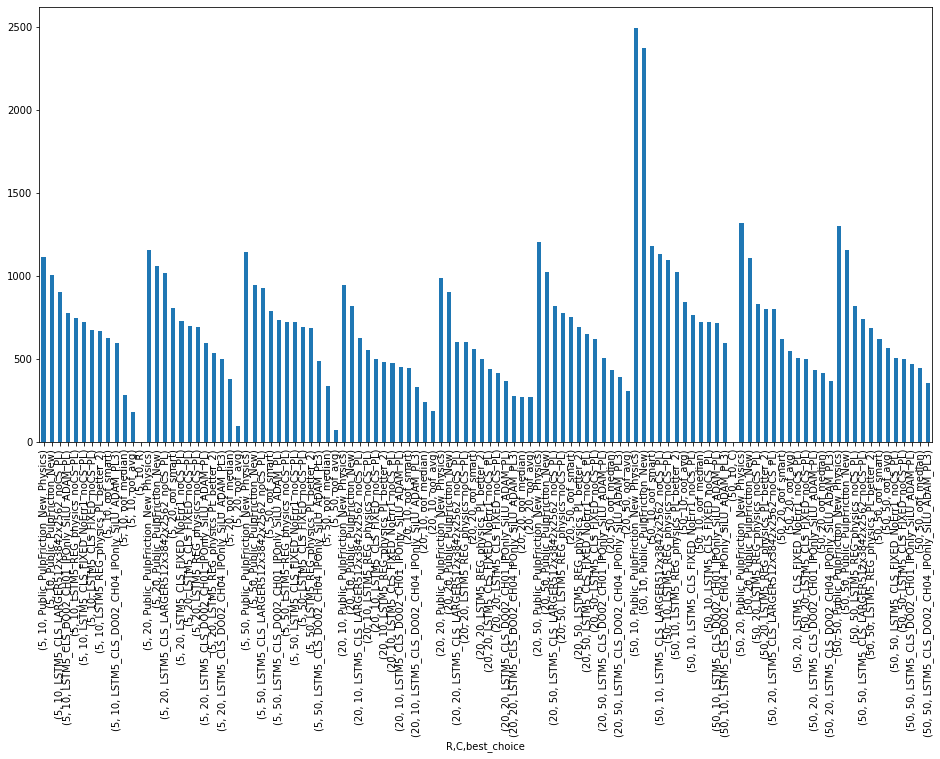

In [79]:
breath_RC_val_counts.plot(kind="bar", figsize=(16,8))

In [68]:
breath_score_df.rename(columns={0:"oof_smart"},inplace=True)

In [69]:
breath_score_df["best_choice"]

,oof_smart,Public_PulpFriction_New,Public_PulpFriction_New_Physics,LSTM5_CLS_FIXED_NoErr1_noCS_PL,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_median,oof_mean,best_choice,R,C
breath_id,,,,,,,,,,,,,,,
1,0.060929,0.044525,0.065615,0.077332,0.065615,0.053898,0.084363,0.100766,0.089049,0.105453,0.072646,0.060929,Public_PulpFriction_New,20,50
2,0.104241,0.121211,0.067878,0.155150,0.218179,0.077575,0.162422,0.082423,0.072726,0.104241,0.096968,0.104241,Public_PulpFriction_New_Physics,20,20
3,0.059317,0.079090,0.083484,0.083484,0.087878,0.092272,0.090075,0.090075,0.068105,0.087878,0.061514,0.059317,0,50,20
4,0.136210,0.221891,0.213103,0.166968,0.204316,0.213103,0.153786,0.202119,0.134013,0.107650,0.136210,0.136210,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,50,50
5,0.026666,0.065454,0.043636,0.036363,0.041212,0.043636,0.019394,0.050908,0.041212,0.036363,0.026666,0.026666,LSTM5_CLS_FIXED_noCS_PL,5,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125740,0.140604,0.140604,0.159998,0.152725,0.138180,0.150301,0.155150,0.159998,0.167271,0.128483,0.138180,0.138180,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,50,50
125742,0.096080,0.107797,0.112483,0.086706,0.121857,0.100766,0.096080,0.084363,0.126544,0.098423,0.096080,0.093736,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,20,10
125743,0.051555,0.053898,0.039838,0.053898,0.063272,0.112483,0.056242,0.051555,0.060929,0.056242,0.053898,0.051555,Public_PulpFriction_New_Physics,20,10


In [46]:
len(breath_score_df), sum(best_counts)

(75450, 75450)

In [ ]:
breath_socre_df

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[:4]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

# Optimization - classification

# Create Submission

['Public_PulpFriction_New', 'Public_PulpFriction_New_Physics', 'LSTM5_CLS_FIXED_NoErr1_noCS_PL', 'LSTM5_REG_physics_PL_better_2', 'LSTM5_CLS_FIXED_noCS_PL', 'LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL', 'LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3', 'LSTM5_CLS_LARGER512x3842x2562_noCS_PL'] (6036000, 11)
Inital Blend OOF: -0.149432
Optimised Blend OOF: -0.148979
----------------------------------------------------------------------
Public_PulpFriction_New                  Optimised Weights: 0.1282545846380366
Public_PulpFriction_New_Physics          Optimised Weights: 0.12763451756463742
LSTM5_CLS_FIXED_NoErr1_noCS_PL           Optimised Weights: 0.12337027156629296
LSTM5_REG_physics_PL_better_2            Optimised Weights: 0.1255652995247794
LSTM5_CLS_FIXED_noCS_PL                  Optimised Weights: 0.1250922651286687
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL  Optimised Weights: 0.12266494469022138
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3 Optimised Weights: 0.1220054353295506
LSTM5_CLS_LARGE

<AxesSubplot:>

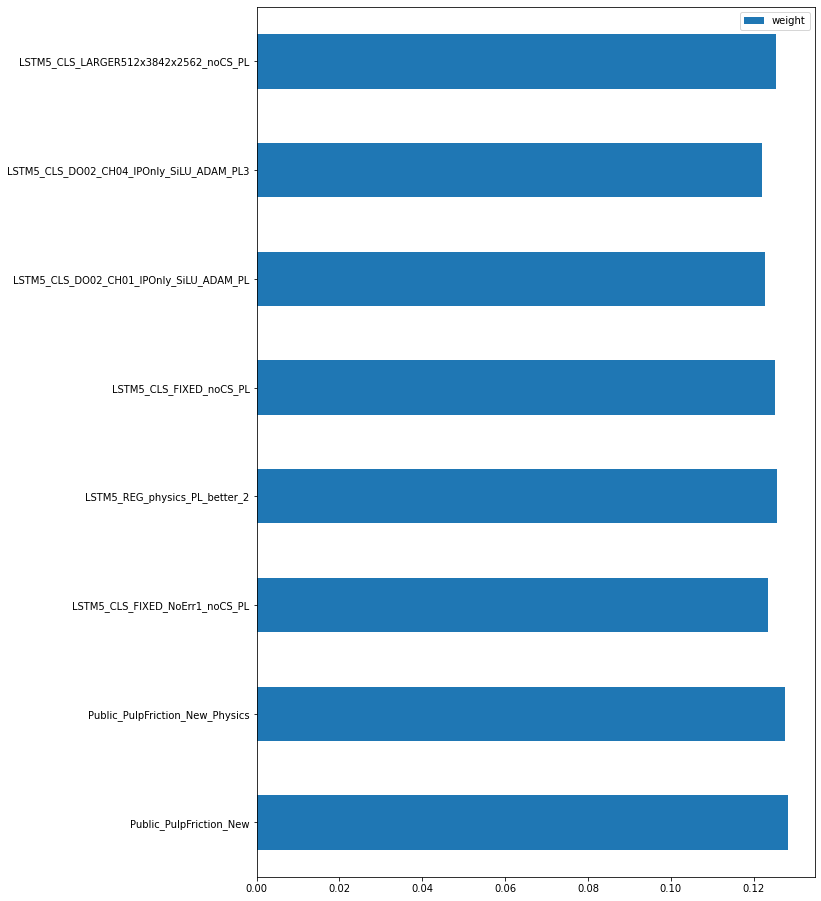

In [14]:
# # weight optimization here .....
# sci_opt_preds = train[model_cols + ["pressure","u_out","fold"]].copy() 
# X = sci_opt_preds[model_cols].values
# print(model_cols, sci_opt_preds.shape)
# def get_score(weights, oof=sci_opt_preds):
#     weights = np.array(weights)
#     oof["prediction"] = (weights * X).sum(axis=1)
#     oof["prediction"] = transform_pv(oof["prediction"])
#     return oof.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["prediction"],1-df["u_out"])).mean()

# tol = 1e-10
# init_guess = [1 / len(model_cols)] * len(model_cols)
# bnds = [(-1, 1) for _ in range(len(model_cols))]
# print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
# res_scipy = minimize(fun = get_score, 
#                     x0 = init_guess, 
#                     method = 'Nelder-Mead', 
#                     bounds = bnds, 
#                     tol = tol)
# print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
# sci_cv_score = -res_scipy.fun
# print('-' * 70)
# for n, key in enumerate(model_cols):
#     print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
# ws = res_scipy.x 
# pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

In [15]:
# weights here ....        
use_sci = False
if use_sci:
    train["pressure_smart"] = transform_pv((train[list(subs.keys())] * ws).sum(axis=1))
else:
    train["pressure_smart"] = transform_pv(smart_avg(train[list(subs.keys())],axis=1))
CVs = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["pressure_smart"],1-df["u_out"]))
CV = np.mean(CVs)
print(CVs)
print("Ensemble CV: Mean {:.4f}, std {:.4f}".format(np.mean(CVs), np.std(CVs)))

Inliers:  1965186 -> compute mean
Outliers: 4070814 -> compute median
Total:    6036000
fold
0    0.150487
1    0.145829
2    0.146295
3    0.148521
4    0.147700
dtype: float64
Ensemble CV: Mean 0.1478, std 0.0017


In [16]:
id_score = train.groupby("breath_id").apply(lambda df: cal_mae_metric(df["pressure"], df["pressure_smart"],1-df["u_out"]))

In [17]:
id_score.describe()

count    75450.000000
mean         0.146736
std          0.238763
min          0.002197
25%          0.058181
50%          0.089049
75%          0.149676
max         20.749949
dtype: float64

In [18]:
np.sum(id_score > 1)

820

In [19]:
good_ids = list(id_score[id_score < 1].index)

In [20]:
good_train = train.query(f"breath_id in {good_ids}")

In [24]:
# len(id_score)

In [25]:
# drop_id_1 = np.array(id_score[id_score > 1].index)
# drop_id_2 = np.array(id_score[id_score > 2].index)
# np.save("../input/large_error_id_1", drop_id_1)
# np.save("../input/large_error_id_2", drop_id_2)

In [22]:
for fold in tqdm(range(5)):
    sub_keys = [key+f"_{fold}" for key in subs.keys()]
    #test_fold_pred = transform_pv((sub_all[sub_keys] * ws).sum(axis=1))
    test_fold_pred = transform_pv(smart_avg(sub_all[sub_keys], axis=1))
    sub_fold = sub_all[["id"]].copy()
    sub_fold[f'preds_fold{fold}'] = test_fold_pred
    sub_fold.to_csv(ensemble_folder + f"/test_fold{fold}.csv",index=False)

if use_sci:
    sub_all["pressure"] = transform_pv((sub_all[model_cols] * ws).sum(axis=1))
else:
    sub_all["pressure"] = transform_pv(smart_avg(sub_all[model_cols], axis=1))
#sub_all.to_csv(ensemble_folder + f"/sub_all_{CV*1e5:.0f}.csv")
sub_all[["id","pressure"]].to_csv(ensemble_folder + f"/submission_{CV*1e5:.0f}.csv",index=False)
print(sub_all.shape, train.shape)
sub_all

  0%|                                                                                     | 0/5 [00:00<?, ?it/s]

Inliers:  1393984 -> compute mean
Outliers: 2630016 -> compute median
Total:    4024000


 20%|███████████████▍                                                             | 1/5 [00:06<00:27,  6.95s/it]

Inliers:  1393529 -> compute mean
Outliers: 2630471 -> compute median
Total:    4024000


 40%|██████████████████████████████▊                                              | 2/5 [00:13<00:19,  6.65s/it]

Inliers:  1392673 -> compute mean
Outliers: 2631327 -> compute median
Total:    4024000


 60%|██████████████████████████████████████████████▏                              | 3/5 [00:20<00:13,  6.64s/it]

Inliers:  1396801 -> compute mean
Outliers: 2627199 -> compute median
Total:    4024000


 80%|█████████████████████████████████████████████████████████████▌               | 4/5 [00:26<00:06,  6.62s/it]

Inliers:  1391217 -> compute mean
Outliers: 2632783 -> compute median
Total:    4024000


100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.65s/it]


Inliers:  1465104 -> compute mean
Outliers: 2558896 -> compute median
Total:    4024000
(4024000, 50) (6036000, 21)


,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,Public_PulpFriction_New_Physics_0,Public_PulpFriction_New_Physics_1,...,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_0,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_1,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_2,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_4,LSTM5_CLS_LARGER512x3842x2562_noCS_PL
0,1,6.259305,6.329606,6.329606,6.329606,6.259304,6.329606,6.329607,6.329606,6.259304,...,6.259305,6.259305,6.189002,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305
1,2,5.907794,5.978096,5.978096,5.978096,5.907794,5.978096,5.978096,5.978096,5.978096,...,5.907794,5.907794,5.978096,5.907794,5.978096,5.978096,5.907794,5.907794,5.978096,5.978096
2,3,7.102930,7.032628,7.173232,7.102930,7.102930,7.173232,7.102930,6.962326,7.102930,...,7.102930,7.102930,7.102930,7.102930,7.102930,7.173232,7.102930,7.102930,7.102930,7.102930
3,4,7.595045,7.595045,7.735649,7.595045,7.595045,7.665347,7.665347,7.665347,7.665347,...,7.524743,7.665347,7.665347,7.595045,7.595045,7.595045,7.595045,7.595045,7.665347,7.595045
4,5,9.071390,9.141692,9.211994,9.001088,9.141692,9.141692,9.141693,9.141692,9.282296,...,9.001088,9.141693,9.071390,9.071390,9.071390,9.141693,9.071390,9.141693,9.141693,9.141693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,10.758642,6.189002,6.259304,6.189002,6.259304,6.189002,6.189002,6.259304,6.189002,...,14.484656,11.813174,16.593720,14.133145,9.071390,10.125923,11.391361,11.672570,11.250757,11.250757
4023996,4023997,10.899246,6.329606,6.189002,6.259304,6.189002,6.259304,6.259305,6.259304,6.259304,...,14.554958,11.883476,13.641030,12.938008,9.071390,55.330202,11.602268,11.883476,11.602268,11.602268
4023997,4023998,11.180455,6.329606,6.470211,6.470211,6.470211,6.470211,6.470211,6.470211,6.470211,...,14.554958,12.305289,13.781634,13.359821,9.141693,12.024081,11.813174,11.883476,12.938008,11.883476
4023998,4023999,11.461663,6.189002,6.259304,6.189002,6.259304,6.189002,6.189002,6.189002,6.189002,...,14.554958,12.727102,13.781634,14.133145,9.282297,11.883476,11.813174,12.445893,13.289519,11.883476


# Best Public Score One

In [23]:
pub_sub1 = pd.read_csv("../output/1336_submission.csv")
pub_sub2 = pd.read_csv("../output/1348_submission.csv")

In [24]:
pub_sub = pub_sub1.rename(columns={"pressure":"sub_1336"})
pub_sub["sub_1348"] = pub_sub2["pressure"]
pub_sub[f"cv_{CV*1e4:.0f}"] = sub_all["pressure"]

In [25]:
pub_sub["pressure"] = transform_pv(smart_avg(pub_sub[["sub_1336","sub_1348",f"cv_{CV*1e4:.0f}"]],axis=1))

Inliers:  1640204 -> compute mean
Outliers: 2383796 -> compute median
Total:    4024000


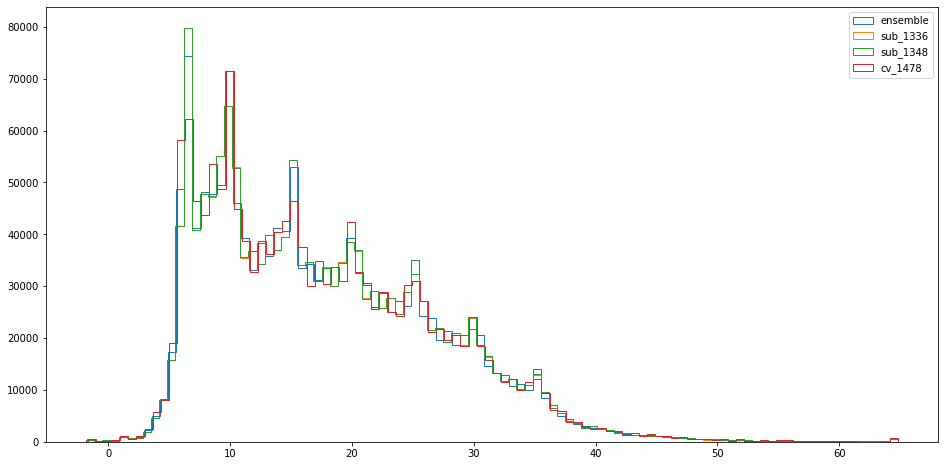

In [34]:
fig,ax= plt.subplots(1,1,figsize=(16,8))
ax.hist(pub_sub.loc[test.query("u_out==0").index,"pressure"], bins=100, label="ensemble", alpha=1,histtype="step")
ax.hist(pub_sub.loc[test.query("u_out==0").index,"sub_1336"], bins=100, label="sub_1336", alpha=1,histtype="step")
ax.hist(pub_sub.loc[test.query("u_out==0").index,"sub_1348"], bins=100, label="sub_1348", alpha=1,histtype="step")
ax.hist(pub_sub.loc[test.query("u_out==0").index, f"cv_{CV*1e4:.0f}"], bins=100, label=f"cv_{CV*1e4:.0f}", alpha=1,histtype="step")
plt.legend()
plt.show()

In [38]:
pub_sub[["id","pressure"]].to_csv(ensemble_folder + f"/submission_{CV*1e5:.0f}_withPub.csv",index=False)